# Graph neural network - CaMML course

# Introduction

# Graph theory

# How to do a GNN?

Thanks to this approach we can transform the theory into an useable algorithm.

To do so, we will take the time to build piece by piece our own GNN in this section. 

First of all, we need to have access to a sufficient amount of data to train our GNN, for this, the __[Material Project](https://legacy.materialsproject.org/)__ database will be used. Even if we could train our GNN upon any property, we will only focus on the prediction of the formation energy of the solid using its structure and its composition.

The extraction and handeling of the data will be similar to what is shown in the [matminer tutorial](https://github.com/hackingmaterials/matminer_examples/blob/main/matminer_examples/).

In [105]:
# Here we will take some libraries to construct the neural-networks using torch.
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Here are some diverse modules and functions necessary.
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# ASE and pymatgen modules
from pymatgen.io.ase import AseAtomsAdaptor
from ase.neighborlist import neighbor_list

# matminer
# Be mindful that the MPDataRetrieval only works for the old MP data base!
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

## Data aquisition

In [2]:
# To ensure a reproducible results, we put the same random seed.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
mpdr = MPDataRetrieval("") # I am using MP because the other one crashes and I have enough of waiting 1h just for it to crash.

You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.


In [ ]:
# Can be long (~10min to grab all the necesary 126335 datas).
df = mpdr.get_dataframe(criteria={}, properties=['formation_energy_per_atom', 'pretty_formula',"structure"])

100%|██████████| 126335/126335 [11:25<00:00, 184.28it/s]


Now that the data base is ready, with only three columns needed to train our GNN upon:
 - The composition
 - The structure
 - The formation energy (the property we wish to predict)
 

In [40]:
df

,formation_energy_per_atom,pretty_formula,structure
material_id,,,
mp-1001788,-0.020860,ZrB6,"[[0. 0. 0.] Zr, [0.80207057 2.029387 2.02938..."
mp-1002206,0.537123,SiC,"[[0. 0. 0.] Si, [2.0251 2.0251 2.0251] C]"
mp-1004524,0.234287,HPbI3,"[[3.1221065 3.1221065 3.1221065] H, [0. 0. 0.]..."
mp-1008492,-0.349239,BrCl,"[[0. 0. 0.] Br, [0. 0. 3.9053505..."
mp-1011260,-2.517135,EuFeO3,"[[ 2.747224 2.72097164 -1.9501425 ] Eu, [5...."
...,...,...,...
mvc-5634,-2.022086,Ca2CuIrO6,"[[3.15778709 8.03614231 5.77105139] Ca, [0.340..."
mvc-6019,-1.619846,Zn(SnO2)2,"[[ 0. 11.36829898 1.84505467] Zn, [0...."
mvc-8011,-1.584384,ZnFeAs2O7,"[[0.71270026 8.84632777 7.89206318] Zn, [5.112..."


If we then look at the repartition of the *formation energy per atom* in function of the database, we have the histogram below.

[Text(0.5, 0, '$\\mathrm{E}_\\mathrm{f}/\\mathrm{atom}$'),
 Text(0, 0.5, 'Number of examples')]

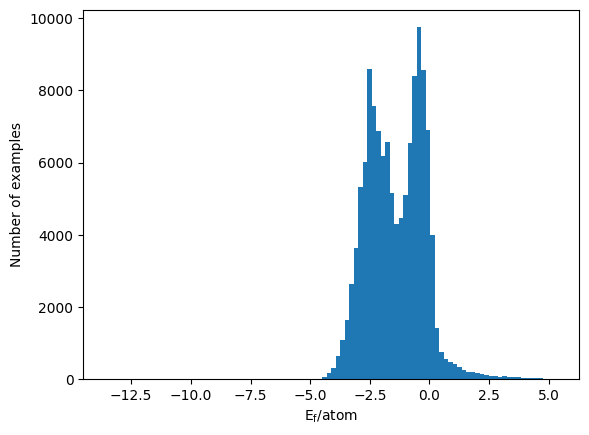

In [44]:
fig, ax = plt.subplots()
ax.hist(df["formation_energy_per_atom"], bins=100)
ax.set(xlabel="$\mathrm{E}_\mathrm{f}/\mathrm{atom}$", ylabel="Number of examples")

## Transforming the data into a graph.

    Transforming a structure into a graph.

At last we have a curated database in function of the target property, the formation energy.

Yet, we still lacks a graph representation of the structure using node and edges. To do so, we can say that each atoms of each structures are a **node** and, their neigbhor the **edges**.

    Encoding information.

As the edge and the node is defined, one last step still remains before the data is ready, we need to encode some informations inside the node and the edge to allow the machine learning to know the difference in between a Li next to an O and a I next to a Fe.


_Where can we encode the information?_

Saving information inside the node seems very intuitive because we simply say that one node is one atom, such that the information of the atom type seems obvious.

As for the interactions, we can store this information inside the edges of the node, this is the **edge embedding**.

The simplest edge embedding would be the atomic connexion; yet, we can also store further informations like the bond length, the bond angle, etc...

Here we will be modest and only keep the atomic connexion and the bond length as edge features (similar to a crystal graph convolutional neural networks).

### The Node: Encoding the nature of the atom

To encode the nature of the atom, one simple way would be to make an array of 118 entries (for each atoms), then put a 1 where this atom is inside the periodic table of elements.

This method called *one hot encoding* is here useful because it will reduce drastically the memory needed to identify the data base while being really easy to read.

In [ ]:
def one_hot_encode_z(atomic_number:int):
    """We return a onehot encoding of the periodic table of elements, inputting the Z number gives the good onehot encoding for the atom in question."""
    vector = np.zeros(118)
    vector[atomic_number-1] = 1
    return vector

In [96]:
node_features = torch.tensor([one_hot_encode_z(site.species.elements[0].Z) for site in df["structure"].iloc[0]])
# Here our atom is Zr with Z=40, so we look at the 39th place to find it back.
print(node_features[0][39])
print(node_features[0])

tensor(1., dtype=torch.float64)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


### The Edge : Keeping track of the atom connexions.

Keeping track of the atom connexion is not as hard has one may think. Indeed, we can simply use a prebuilt function inside [`ase`](https://wiki.fysik.dtu.dk/ase/) to output the list of neighboring connexions and their length given a cutoff radius.

In [116]:
cutoff_radius = 4 # Angstrom

In [117]:
atoms = AseAtomsAdaptor.get_atoms(df["structure"].iloc[0])
edge_src, edge_dst, edge_len = neighbor_list(
                "ijd", atoms, cutoff=cutoff_radius, self_interaction=False
            )
# Cell parameter of atoms
atoms.cell

Cell([4.058774, 4.058774, 4.058774])

The three variables show the origin of the bond, its destination and the length.
In fact, if we visualize the graph of the connections it becomes evident that for such a crystal structure with cell parameters almost equal to $4 \AA$, each of the atoms will be connected.

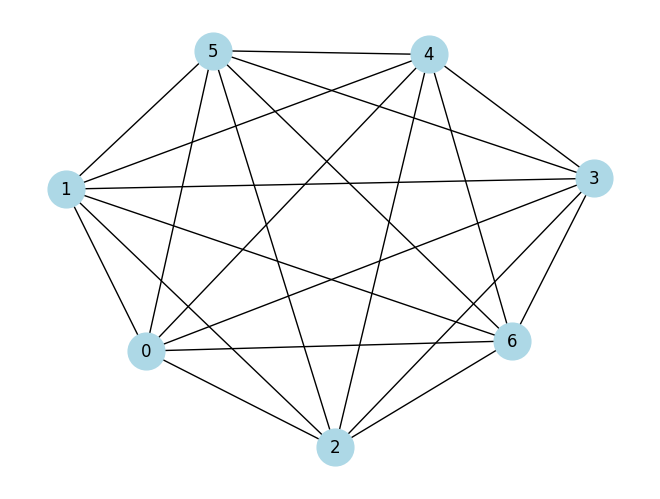

In [128]:
G = nx.Graph()
for s1, s2 in zip(edge_src, edge_dst):
    G.add_edge(s1, s2)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=700, font_size=12)
plt.show()

### The Edge : Length of the connexion.

We have the connexions and the length so, what are we waiting for?

In fact, it would not be wise to use the bond length value for the connexion, a single value would not be enough for the GNN to assess a pattern with distances while having a good description of the environment.

One way would be to embbed the edges using a basis set of gaussians that will describe the space in between $0$ and $4 \AA$, in which the bond length will be mapped.

In [178]:
# How many gaussian to describe this space?
number_of_gaussians = 80

In [179]:
# one hot encode bond length using gaussians.
filter = np.linspace(0, cutoff_radius, number_of_gaussians)
edge_feat = np.exp(
    -((edge_len[..., None] - filter) ** 2) / (filter[1] - filter[0]) ** 2
)

## Storing the data

Once we did all of this, we can try to store all this informations inside a big class that

## Making the GNN

- Where are the nodes and edges?
- Need to split the datas in function of composition in between train, validation and test.
- Need to do batches of the datas.

- run the entire GNN code to see if it is working as expected with the new inputs.

- Create GNN "step by step".

## --- DRAFT ---

In [ ]:
# To ensure a reproducible results, we put the same random seed.

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# We will also take the matbench data base log_gvrh data set with 10,987 VRH-average shear moduli calculated using DFT. As a starting data base for training and testing the GNN we will create in this section.

dataset = MaterialsDataset(
    "./inputs/bulk-modulus-dataset.json",
    cutoff=4,  # cutoff radius for finding neighbours
    num_gaussians=40,  # number of gaussians in edge embedding
)
# Sample of the data to visualise it.
sample = dataset[10]
# You can visualise one of structure that was sampled.
# Here, we can see the crystal structure in the left and the graph this crystal structure will provide on the right:
plot_sample(sample)

# From here we split the data set into a training and a validation data set.
train_set, valid_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(valid_set)}')
print(f'Number of testing examples: {len(test_set)}')

Now that we have selected data treatment 

In [ ]:
# Now the data is splitted into batches to make the datas more manageable to compute.
# collate_fn allows to automatically handle grouping multiple graphs into a batch.
BATCH_SIZE = 32

# Training part of the data.
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True,
)
# Validation part of the data.
valid_loader = DataLoader(
    valid_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)
# Testing part of the data.
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, collate_fn=collate_fn,
)

### Convolution

In [ ]:
# I first need to do convolution
# EXPLAIN WHY
# EXPLAIN ALL THE STEPS
class GraphConvolution(nn.Module):
    
    def __init__(self, node_feat_dim, edge_feat_dim):
        """
        Convolutional layer for graphs.
        
        Parameters
        ----------
        node_feat_dim : int
          Number of node features.
        edge_feat_dim : int
          Number of edge features.
        """
        super().__init__()

        # linear layer used for the gated MLP
        self.lin1 = nn.Linear(
            2 * node_feat_dim + edge_feat_dim,
            2 * node_feat_dim,
        )

        # normalisation layers
        self.bn1 = nn.BatchNorm1d(2 * node_feat_dim)
        self.bn2 = nn.BatchNorm1d(node_feat_dim)

    def forward(self, node_feat, edge_feat, edge_src, edge_dst):
        """Perform the convolution.

        Parameters
        ----------
        node_feat : Tensor
            The node features.
        edge_feat : Tensor
            The edge features
        edge_src : Tensor
            The indices of the central nodes for the edges.
        edge_dst : Tensor
            The indices of the desintation nodes for the edges.
        """
        # concatenate node and edge features
        m = torch.cat([node_feat[edge_src], node_feat[edge_dst], edge_feat], dim=1)

        # gated MLP
        z = self.lin1(m)
        z = self.bn1(z)
        z1, z2 = z.chunk(2, dim=1)
        z1 = nn.Sigmoid()(z1)
        z2 = nn.Softplus()(z2)
        z = z1 * z2

        # pool features
        z = scatter_sum(z, edge_src, dim=0, dim_size=node_feat.shape[0])
        
        # pass through normalisation layer
        return nn.Softplus()(self.bn2(z) + node_feat)


# Then I do CGCNN 
# WHY
# EXPLAIN ALL THE LINES.
class CGCNN(nn.Module):
    def __init__(
        self,
        node_feat_dim,
        edge_feat_dim,
        node_hidden_dim=64,
        num_graph_conv_layers=3,
        fc_feat_dim=128
    ):
        """
        Crystal Graph Convolutional Neural Network 

        Parameters
        ----------
        node_feat_dim : int
          Number of initial node features from one-hot encoding.
        edge_feat_dim : int
          Number of bond features.
        node_hidden_dim : int
          The number of features in the node embedding.
        num_graph_conv_layers: int
          Number of convolutional layers.
        fc_feat_dim: int
          Number of hidden features after pooling.
        """
        super().__init__()

        # dense layer to transform one-hot encoded node features to embedding
        self.embedding = nn.Linear(node_feat_dim, node_hidden_dim)

        # set up the convolutions
        convs = []
        for _ in range(num_graph_conv_layers):
            convs.append(GraphConvolution(node_feat_dim=node_hidden_dim, edge_feat_dim=edge_feat_dim))
        self.convs = nn.ModuleList(convs)

        # dense layer to turn final node embeddings to the crystal features
        self.conv_to_fc = nn.Sequential(
           nn.Linear(node_hidden_dim, fc_feat_dim), nn.Softplus()
        )

        # dense layer to get the final target value
        self.fc_out = nn.Linear(fc_feat_dim, 1)

    def forward(self, batch):
        """
        Predict the target property given a batch of data.

        Parameters
        ----------
        batch : Batch
            The data to pass through the network.
        """
        # get initial node embedding
        node_feat = self.embedding(batch.node_feat)

        # apply convolutions
        for conv_func in self.convs:
            node_feat = conv_func(node_feat, batch.edge_feat, batch.edge_src, batch.edge_dst)

        # pool node vectors
        crys_feat = scatter_mean(node_feat, batch.batch, dim=0, dim_size=batch.batch.max() + 1)

        # pass pooled vector through FC layer with activation
        crys_feat = self.conv_to_fc(crys_feat)

        # pass crystal features through final fully-connected layer
        return self.fc_out(crys_feat)

# Application: Use of GNN to run an MD.